In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import random
import healpy as hp

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

In [2]:
os.getenv('ENDPOINT_URL') 

'http://rook-ceph-rgw-nautiluss3.rook'

In [4]:
tbl_file = 's3://llc/Tables/LLC_modis_noise.parquet'
yes_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://llc/Tables/LLC_modis_noise.parquet


In [5]:
tbl_file1 = 's3://llc/Tables/ulmo2_test.parquet'
yes_table1 = ulmo_io.load_main_table(tbl_file1)

Read main table: s3://llc/Tables/ulmo2_test.parquet


In [6]:
tbl_file2 = 's3://llc/Tables/LLC_modis_noise_track.parquet'
yes_table2 = ulmo_io.load_main_table(tbl_file2)

Read main table: s3://llc/Tables/LLC_modis_noise_track.parquet


In [7]:
mod_file = 's3://modis-l2/Tables/MODIS_L2_std.parquet'
mod_table = ulmo_io.load_main_table(mod_file)

Read main table: s3://modis-l2/Tables/MODIS_L2_std.parquet


In [8]:
mod_table['DT'] = mod_table.Tmax - mod_table.Tmin
mod_table['DT_p'] = mod_table.T90 - mod_table.T10

In [9]:
clear = mod_table.clear_fraction < 0.005
value = ~ mod_table.LL.isnull()
tbl = mod_table[ clear & value]

In [10]:
def evals_to_healpix(eval_tbl, nside, log=False, mask=True):
    """
    Generate a healpix map of where the input
    MHW Systems are located on the globe

    Parameters
    ----------
    mhw_sys : pandas.DataFrame
    nside : int  # nside is a number that sets the resolution of map
    mask : bool, optional

    Returns
    -------
    healpix_array, lats, lons : hp.ma, np.ndarray, np.ndarray

    """
    # Grab lats, lons
    lats = eval_tbl.lat.values
    lons = eval_tbl.lon.values

    # Grab LL values
    vals = eval_tbl.LL.values

    # Healpix coords
    theta = (90 - lats) * np.pi / 180.  # convert into radians
    phi = lons * np.pi / 180.
    idx_all = hp.pixelfunc.ang2pix(nside, theta, phi) # returns the healpix pixel numbers that correspond to theta and phi values

    # Count events
    npix_hp = hp.nside2npix(nside)  # returns the number of pixels on map, based on nside parameter
    all_events = np.ma.masked_array(np.zeros(npix_hp, dtype='int')) # array of all pixels on map
    all_values = np.ma.masked_array(np.zeros(npix_hp, dtype='int')) # will contain a sum of all LL values in the area

    #A masked array takes an input data array and mask array of same size; mask is a sequence of boolean values (True == turn mask on; False ==  unmasked)
    for i, idx in enumerate(idx_all):
        all_events[idx] += 1 # pixels concentrated with data pts >= 1 ; those without data remain 0
        all_values[idx] += vals[i] 

    zero = all_events == 0 
    if log:  #(defaults to False)
        float_events = np.zeros_like(all_events).astype(float) # Return an array of zeros with the same shape and type as a given array
        float_values = np.zeros_like(all_events).astype(float)

        float_events[~zero] = np.log10(all_events[~zero].astype(float)) 
# ~ operator is called the complement bitwise operator 
# inverts the True/False values
# [~zero] selects pixels where the cutouts are (where events = 1 exist)
        float_values[~zero] = all_values[~zero]/all_events[~zero]
    else:
        float_events = all_events.astype(float)
        float_values = all_values.astype(float)


    # Mask
    hpma = hp.ma(float_events)
    hpma1 = hp.ma(float_values)
    if mask:  # if you want to mask float_events
        hpma.mask = zero # current mask set to zero array, where Trues (no events) are masked
        hpma1.mask = zero 

    # Angles
    hp_lons, hp_lats = hp.pixelfunc.pix2ang(nside, np.arange(npix_hp), lonlat=True)

    # Return
    return hpma, hp_lons, hp_lats, hpma1

In [29]:
def show_spatial_two(tbl1:pd.DataFrame, tbl2:pd.DataFrame, 
                 nside=64, use_log=True, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='coolwarm', show=True):
    """Generate a global map of the location of the input
    cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = evals_to_healpix(
        tbl1, nside, log=use_log, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = evals_to_healpix(
        tbl2, nside, log=use_log, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons1, hp_lats1, hp_values1 - hp_values2, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_values2.mask)
        img = plt.scatter(x=hp_lons2[good],
            y=hp_lats2[good],
            c=hp_values1[good]- hp_values2[good], vmin = -50, vmax = 50, 
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
        clbl = lbl
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])


    # Layout and save
    if show:
        plt.show()

    return ax

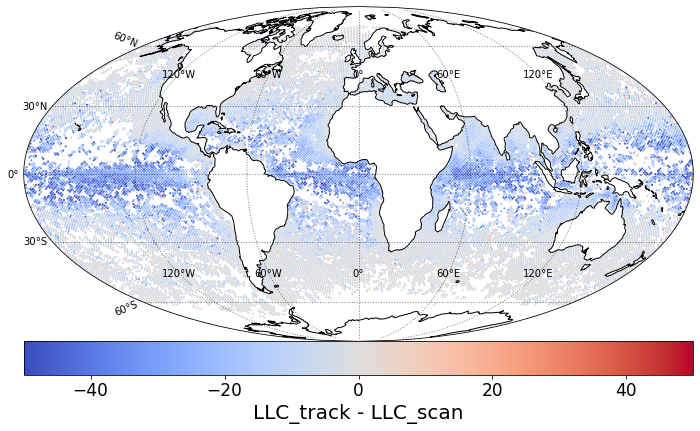

<GeoAxesSubplot:>

In [30]:
show_spatial_two(yes_table2, yes_table, lbl='LLC_track - LLC_scan')

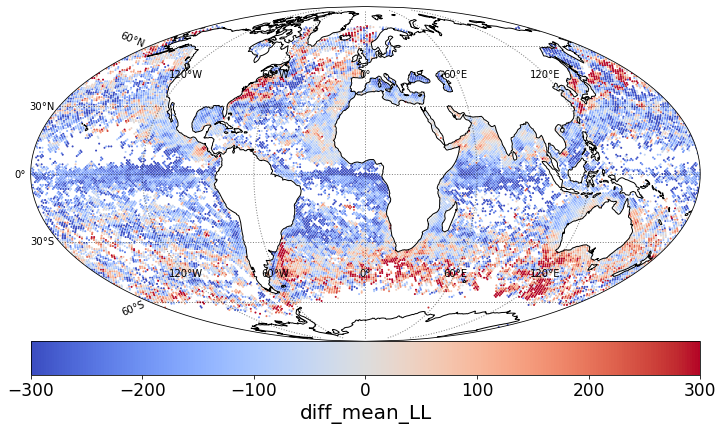

<GeoAxesSubplot:>

In [22]:
show_spatial_two(tbl, yes_table2, lbl='MOD vs LLC_track')

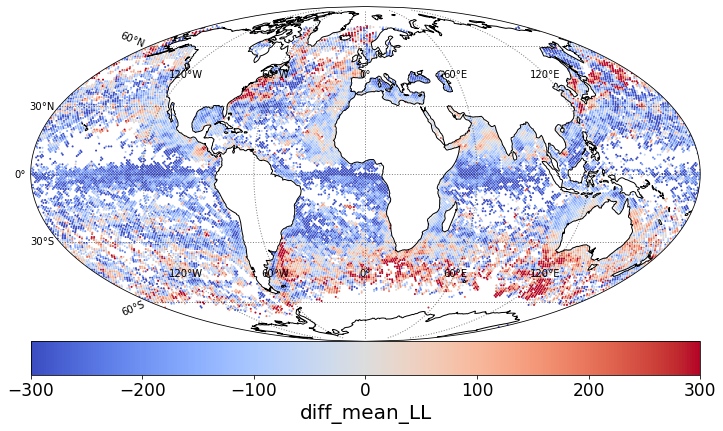

<GeoAxesSubplot:>

In [21]:
show_spatial_two(tbl, yes_table, lbl='MOD vs LLC_scan')

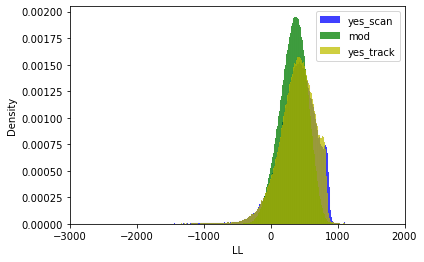

In [27]:
ax = sns.histplot(data= yes_table, x = 'LL', color = 'b', stat = 'density', label = 'yes_scan', binwidth = 10)
ax = sns.histplot(data= tbl, x = 'LL', color = 'g', stat = 'density', label = 'mod', binwidth = 10)
ax = sns.histplot(data= yes_table2, x = 'LL', color = 'y', stat = 'density', label = 'yes_track', binwidth = 10)
ax.set_xlim(-3000., 2000.)
#ax.set_ylim(0., 14000)
ax.legend()